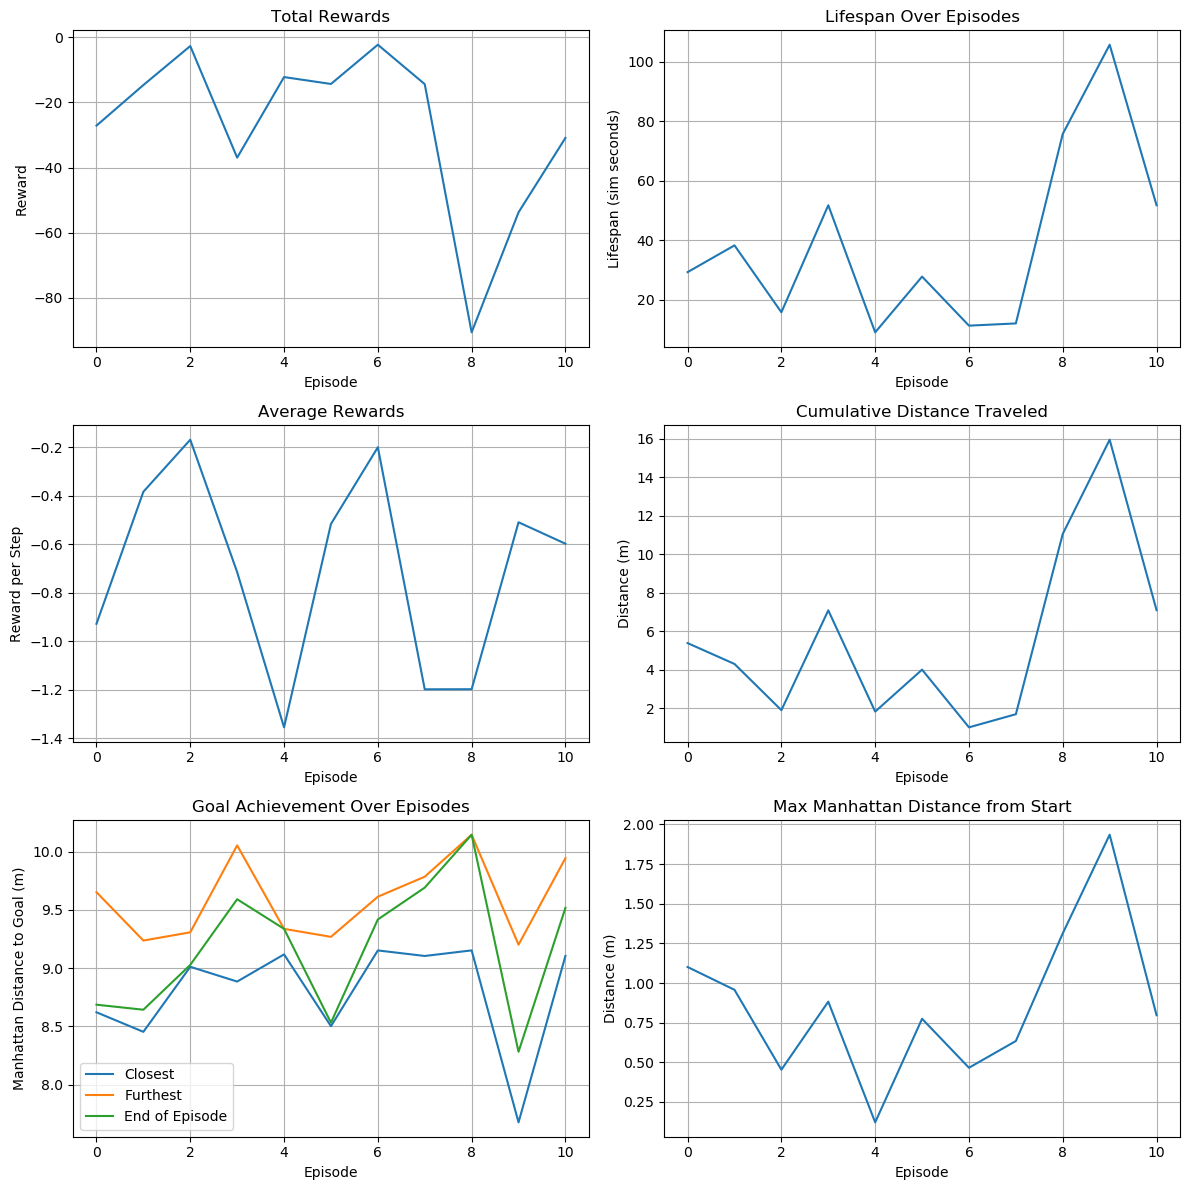

Text(0, 0.5, 'MSE Loss')

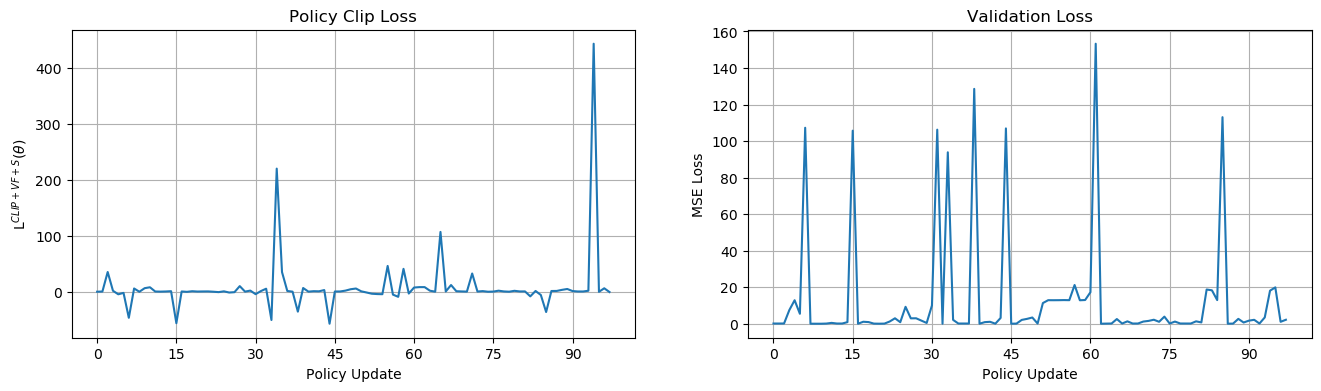

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

# Sorting function to ensure files are processed in numerical order
def sort_key(filename):
    parts = filename.split('_')
    number_part = parts[1].split('.')[0]  # Get the part of the filename that is the number
    return int(number_part)

def get_logs(run_path, folder_name):
    directory_path = os.path.join(run_path, folder_name)
    # List to hold all the values
    values = []

    # Loop through each file in the directory
    for filename in sorted(os.listdir(directory_path), key=sort_key):
        if filename.endswith('.txt'):
            # Construct the full file path
            file_path = os.path.join(directory_path, filename)
            # Open and read the file
            with open(file_path, 'r') as file:
                for line in file:
                    # Append the line to the values list
                    values.append(line.strip())  # No need to convert to float for goal data

    return values


# Path to the directory containing the files
run = '/media/ryan/DataPad/ros_ws/src/notspot_sim_py/src/reinforcement_learning/runs/2024_04_23_19_35_54'

rewards = [float(reward) for reward in get_logs(run, "rewards")]
lifespans = [int(lifespan)*0.75 for lifespan in get_logs(run, "steps")]
closest_goal = [float(dist) for i, dist in enumerate(get_logs(run, "goal")) if i%3 == 0]
furthest_goal = [float(dist) for i, dist in enumerate(get_logs(run, "goal")) if i%3 == 1]
ending_goal = [float(dist) for i, dist in enumerate(get_logs(run, "goal")) if i%3 == 2]
distance_cum = [float(dist) for i, dist in enumerate(get_logs(run, "distance")) if i%2 == 0]
distance_start = [float(dist) for i, dist in enumerate(get_logs(run, "distance")) if i%2 == 1]
rewards_per_step = [reward / lifespan if lifespan > 0 else reward for reward, lifespan in zip(rewards, lifespans)]

policy_loss = [float(loss) for loss in get_logs(run+'/models/loss', "policy")]
value_loss = [float(loss) for loss in get_logs(run+'/models/loss', "value")]


# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

for ax in axs.flatten():
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.grid(True)


# Plot total rewards over episodes
axs[0, 0].plot(rewards)
axs[0, 0].set_title('Total Rewards')
axs[0, 0].set_xlabel('Episode')
axs[0, 0].set_ylabel('Reward')
# axs[0, 0].legend()

# Plot average rewards per step over episodes
axs[1, 0].plot( rewards_per_step)
axs[1, 0].set_title('Average Rewards')
axs[1, 0].set_xlabel('Episode')
axs[1, 0].set_ylabel('Reward per Step')
# axs[0, 1].legend()

# Plot lifespan over episodes
axs[0, 1].plot(lifespans)
axs[0, 1].set_xlabel('Episode')
axs[0, 1].set_ylabel('Lifespan (sim seconds)')
axs[0, 1].set_title('Lifespan Over Episodes')
# axs[1, 0].legend()

# Plot goal achievement over episodes
axs[2, 0].plot(closest_goal, label='Closest')
axs[2, 0].plot(furthest_goal, label='Furthest')
axs[2, 0].plot(ending_goal, label='End of Episode')
axs[2, 0].set_xlabel('Episode')
axs[2, 0].set_ylabel('Manhattan Distance to Goal (m)')
axs[2, 0].set_title('Goal Achievement Over Episodes')
axs[2, 0].legend()

# Plot cumulative distance traveled over episodes
axs[1, 1].plot(distance_cum, label='Distance')
axs[1, 1].set_title('Cumulative Distance Traveled')
axs[1, 1].set_xlabel('Episode')
axs[1, 1].set_ylabel('Distance (m)')
# axs[1, 1].legend()

# Hide the empty subplot
axs[2, 1].plot(distance_start)
axs[2, 1].set_title('Max Manhattan Distance from Start')
axs[2, 1].set_xlabel('Episode')
axs[2, 1].set_ylabel('Distance (m)')

plt.tight_layout()
plt.show()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

for ax in axs.flatten():
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.grid(True)


# Plot total rewards over episodes
axs[0].plot(policy_loss)
axs[0].set_title('Policy Clip Loss')
axs[0].set_xlabel('Policy Update')
axs[0].set_ylabel(r'L$^{CLIP+VF+S}$($\theta$)')
# axs[0].set_ybound(-25,25)
# axs[0].legend()

# Plot average rewards per step over episodes
axs[1].plot(value_loss)
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Policy Update')
axs[1].set_ylabel('MSE Loss')
# axs[1].set_ybound(-0.25,100)
# axs[1].legend()


In [74]:
import os
import re
import time

def find_files_with_number(folder_path, number):
    """
    Find files in a folder containing a specified number in their filename
    and return their last modified timestamp.

    Args:
        folder_path (str): Path to the folder to search.
        number (int): The number to search for in filenames.

    Returns:
        dict: A dictionary containing filenames as keys and their last modified timestamps as values.
    """
    file_timestamps = {}
    for filename in os.listdir(folder_path):
        if '_' + str(number) in filename:  # Search for the number in filename
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):  # Check if it's a file
                last_modified = os.path.getmtime(file_path)  # Get last modified timestamp
                file_timestamps[file_path] = last_modified
    return file_timestamps

def delete_files_modified_after(folder_path, timestamp):
    """
    Delete files in a folder that were modified after a given timestamp.

    Args:
        folder_path (str): Path to the folder to delete files from.
        timestamp (float): Timestamp to compare against for deletion.
    """
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):  # Check if it's a file
            last_modified = os.path.getmtime(file_path)  # Get last modified timestamp
            if last_modified > timestamp:
                os.remove(file_path)  # Delete file

# Example usage:
folder_path = '/media/ryan/DataPad/ros_ws/src/notspot_sim_py/src/reinforcement_learning/runs/2024_04_23_02_37_44'
folder_path += '/models/loss/value'
number = 140  # Example number to search for
# timestamp = time.time() - (24 * 3600)  # Example: 24 hours ago

# Find files containing the number in their filename and their last modified timestamps
files_with_number = find_files_with_number(folder_path, number)
print("Files containing number {} and their last modified timestamps:".format(number))
for filename, timestamp in files_with_number.items():
    print(filename, timestamp)

# Delete files modified after the specified timestamp
delete_files_modified_after(folder_path, timestamp)
print("Files modified after timestamp {} have been deleted.".format(timestamp))


Files containing number 140 and their last modified timestamps:
/media/ryan/DataPad/ros_ws/src/notspot_sim_py/src/reinforcement_learning/runs/2024_04_23_02_37_44/models/loss/value/loss_140.txt 1713856235.1080124
Files modified after timestamp 1713856235.1080124 have been deleted.
